In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from time import time
from datetime import datetime

import matplotlib.pyplot as plt

import qutip as qp
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit_dynamics import DiscreteSignal

/home/qottmann/anaconda3/envs/pennylane311/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


We perform a simple benchmark scaling the evolution of the Hamiltonian
$$ H = \sum_q \omega_q Z_q + \sum_q g_q Y_q \otimes Y_{q+1} +  \sum_q f_q(t) X_q \otimes X_{q+1} $$
in size. As an objective Hamiltonian, we choose
$$ H_\text{obj} = \sum_q c^X_q X_q \otimes X_{q+1} + c^Y_q Y_q \otimes Y_{q+1} $$
with random (but fixed) coefficients.

In this notebook, we compare forward passes in `PennyLane`, `qutip` and `qiskit-dynamics`. To the best of our knowledge, there is no official `jax` support for qutip, which is why the executions are not just-in-time-compiled, and therefore a bit of an apples-pears comparison.

The notebook as it is was run on laptop with a Intel i7-1260P. The benchmark takes about 10 minutes on this system. We print the versions of the respective libraries at the bottom of this notebook.

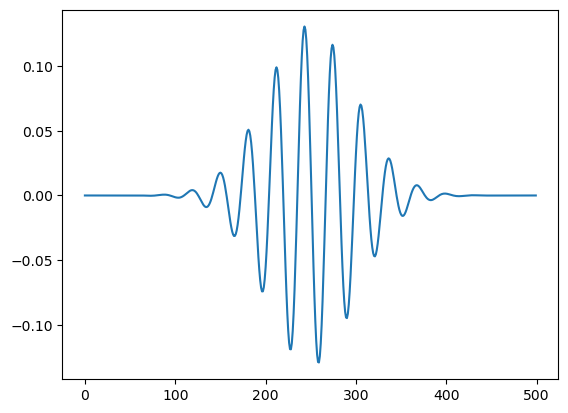

In [2]:
n_wires=2
omega0 = 5.
g0 = 0.01
t_span = jnp.linspace(0., 20., 500)
atol=1e-8

# Control
def amp(p, t):
    sigma = 2.
    # return qml.pulse.pwc((t_span[0], t_span[-1]))(p, t) * jnp.sin(omega[0]*t)
    return p[0] * jnp.exp(-0.5 * ((t - 10.)/sigma)**2) /sigma/jnp.sqrt(2*jnp.pi) * jnp.sin(omega0*t)

t_bins = 1 # degree of polynomial parametrization
key = jax.random.PRNGKey(444)
theta = jax.random.normal(key, shape=(n_wires, t_bins))

plt.plot(amp(theta[0], t_span))

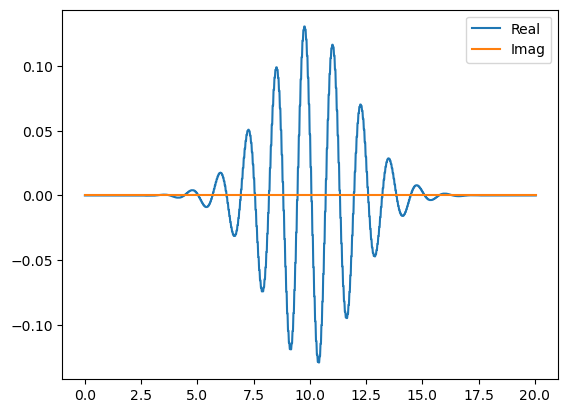

In [3]:
i = 0
dt = np.diff(t_span)[0]
signal = DiscreteSignal(dt=dt, samples=Array(amp(theta[i], t_span))) 
signal.draw(t0=0., tf=signal.duration * signal.dt, n=1000, function='envelope')

In [4]:
def create_evolve(n_wires, mode="PennyLane"):
    omega = omega0 * jnp.ones(n_wires, dtype=float)
    g = g0 * jnp.ones(n_wires, dtype=float)

    # Drift
    Hdrift = [qml.PauliZ(i) for i in range(n_wires)]
    Hdrift += [qml.PauliY(i) @ qml.PauliY((i+1)%n_wires) for i in range(n_wires)]
    cdrift = jnp.concatenate([omega, g])
    H_D = qml.Hamiltonian(cdrift, Hdrift)

    fs = [amp for _ in range(n_wires)]
    Hcontrol = [qml.PauliX(i) @ qml.PauliX((i+1)%n_wires) for i in range(n_wires)]
    H_C = qml.dot(fs, Hcontrol)
    H_pulse = H_D + H_C

    # H_obj
    ops2 = [qml.PauliX(i) @ qml.PauliX((i+1)%n_wires) for i in range(n_wires)]
    ops2 += [qml.PauliY(i) @ qml.PauliY((i+1)%n_wires) for i in range(n_wires)]

    key = jax.random.PRNGKey(1337)
    coeff = jax.random.uniform(key, shape=(len(ops2),))

    H_obj = qml.Hamiltonian(coeff, ops2)
    H_obj_m = jnp.array(qml.matrix(H_obj))

    if mode=="PennyLane":
        dev = qml.device("default.qubit.jax",wires=range(n_wires))
        @jax.jit
        @qml.qnode(dev, interface="jax")
        def evolve(params):
            qml.pulse.ParametrizedEvolution(H_pulse, params, [t_span[0], t_span[-1]], atol=atol)
            return qml.expval(H_obj)

    elif mode=="qutip":
        H_drift = qp.Qobj(np.array(qml.matrix(H_D)))
        def w(i):
            def wrapped(t, args):
                v = args[f"v{i}"]
                return qml.pulse.pwc((t_span[0], t_span[-1]))(v, t) * np.sin(omega[0]*t)
            return wrapped

        H_ts = [qp.Qobj(qml.matrix(op, wire_order=range(n_wires))) for op in Hcontrol]

        H_control = [[H_ts[i], w(i)] for i in range(n_wires)]
        H_pulse_q = qp.QobjEvo([H_drift] + H_control)

        psi0 = np.eye(2**n_wires, dtype=complex)[0]
        psi0 = qp.Qobj(psi0)
        def evolve(params):
            params = np.array(params)
            args = {f"v{i}": params[i] for i in range(n_wires)} 

            # tlist = [t_span[0], t_span[-1]]
            options = qp.solver.Options(nsteps=100000, atol=atol) # necessary to increase max number of steps, otherwise error message
            output = qp.sesolve(H_pulse_q, psi0, [t_span[0], t_span[-1]], args=args, options=options)
            v = qp.Qobj(output.states[-1]).full()
            res = v.conj().T @ H_obj_m @ v
            return np.real(res)
        
    elif mode=="qiskit-dynamics":
        """
        Taken from https://qiskit.org/ecosystem/dynamics/tutorials/optimizing_pulse_sequence.html
        """
        static_hamiltonian = Operator(qml.matrix(H_D))
        drive_terms = [Operator(qml.matrix(op, wire_order=range(n_wires))) for op in Hcontrol]

        ham_solver = Solver(
            hamiltonian_operators=drive_terms,
            static_hamiltonian=static_hamiltonian,
        )
        dt = np.diff(t_span)[0]
        @jax.jit
        def evolve(params):
            signals = [DiscreteSignal(dt=dt, samples=Array(amp(params[i], t_span))) for i in range(n_wires)]

            results = ham_solver.solve(
                y0=np.eye(2**n_wires, dtype=complex)[0],
                t_span=[t_span[0], t_span[-1]],
                signals=signals,
                method='jax_odeint',
                atol=atol,
            )
            v = results.y[-1]
            return jnp.real(v.conj().T @ H_obj_m @ v)

    return evolve

In [5]:
def _timeit(callable, *args, reps=3):

    jittime0 = time()
    res0 = callable(*args)
    dt_jit = time() - jittime0 

    dts = []
    for k in range(reps):
        t0 = time()
        resi = callable(*args)
        dt = time() - t0

        dts.append(dt)
    
    return dt_jit, np.mean(dts), np.std(dts)

In [6]:
def _timeit_jax(callable, *args, reps=3):
    callable.clear_cache()

    jittime0 = time()
    res0 = jax.block_until_ready(callable(*args))
    dt_jit = time() - jittime0 

    dts = []
    for k in range(reps):
        t0 = time()
        resi = jax.block_until_ready(callable(*args))
        dt = time() - t0

        dts.append(dt)
    
    return dt_jit, np.mean(dts), np.std(dts)

In [7]:
modes = ["qutip", "qiskit-dynamics", "PennyLane"]

In [8]:
reps = 3

n_wiress = list(range(2,10))

datan = {}

for mode in modes:
    dt_jit = []
    dtss = []
    ddtss = []
    for i, n_wires in enumerate(n_wiress):
        callable_ = create_evolve(n_wires, mode=mode)

        t_bins = 1
        theta = 0.5 * jnp.ones((n_wires, t_bins))

        if mode=="PennyLane" or mode=="qiskit-dynamics":
            a, b, c = _timeit_jax(callable_, theta, reps=reps)
        if mode=="qutip":
            if n_wires > 6:
                continue
            a, b, c = _timeit(callable_, theta, reps=reps)
        dt_jit.append(a)
        dtss.append(b)
        ddtss.append(c)

        print(f"mode: {mode} - {i+1} / {len(n_wiress)}, n_wires = {n_wires} - jit: {a:.4f}, exec: {b:.4f} +/- {c:.4f}")

    datan[mode] = dict(dtss=dtss, ddtss=ddtss, dt_jit=dt_jit, n_wiress=n_wiress)

mode: qutip - 1 / 8, n_wires = 2 - jit: 6.2107, exec: 4.9175 +/- 0.3618
mode: qutip - 2 / 8, n_wires = 3 - jit: 11.8350, exec: 11.5308 +/- 0.1356
mode: qutip - 3 / 8, n_wires = 4 - jit: 17.1123, exec: 17.0229 +/- 0.0904
mode: qutip - 4 / 8, n_wires = 5 - jit: 24.3733, exec: 25.2911 +/- 1.2418
mode: qutip - 5 / 8, n_wires = 6 - jit: 44.1435, exec: 41.4874 +/- 0.4708
mode: qiskit-dynamics - 1 / 8, n_wires = 2 - jit: 0.5348, exec: 0.0055 +/- 0.0003
mode: qiskit-dynamics - 2 / 8, n_wires = 3 - jit: 0.6849, exec: 0.0094 +/- 0.0008
mode: qiskit-dynamics - 3 / 8, n_wires = 4 - jit: 0.7063, exec: 0.0311 +/- 0.0006
mode: qiskit-dynamics - 4 / 8, n_wires = 5 - jit: 0.9293, exec: 0.1317 +/- 0.0031
mode: qiskit-dynamics - 5 / 8, n_wires = 6 - jit: 1.6211, exec: 0.5574 +/- 0.0057
mode: qiskit-dynamics - 6 / 8, n_wires = 7 - jit: 3.8466, exec: 2.5195 +/- 0.0352
mode: qiskit-dynamics - 7 / 8, n_wires = 8 - jit: 13.3902, exec: 11.9892 +/- 0.0718
mode: qiskit-dynamics - 8 / 8, n_wires = 9 - jit: 84.215

In [9]:
def expfit(x, y):
    y = np.log(y)
    coeff = np.polyfit(x, y, 1) # y=c1 e^(c0 x) => logy = c0 x + log(c1)
    return coeff

In [10]:
name = f"data/{datetime.now().date()}_Forward-pass_PL-QUTIP-QISKIT-INTEL-i7-1260P"
print(name)

data/2023-09-07_Forward-pass_PL-QUTIP-QISKIT-INTEL-i7-1260P


In [11]:
np.savez(name, **datan)

In [12]:
try:
    data = np.load(name + ".npz", allow_pickle=True)
except:
    print(f"no data under name {name}.npz yet")

In [13]:
plot_modes = data.files
from_ = 1 # from which size to fit

In [14]:
data.files

['qutip', 'qiskit-dynamics', 'PennyLane']

Text(0.5, 0, 'N')

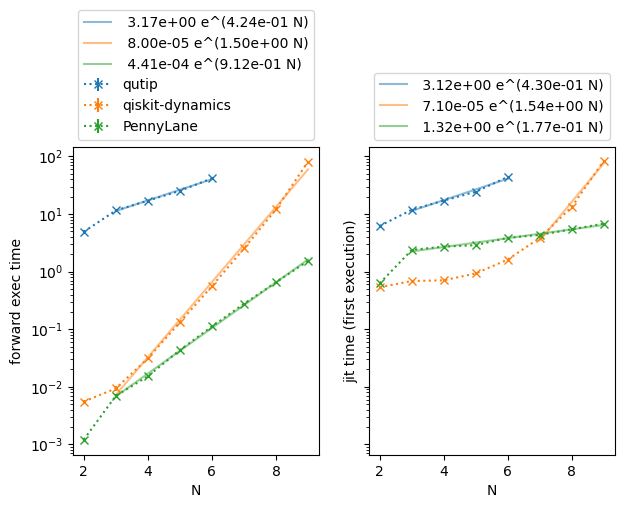

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(7,4), sharey=True)
color = ["tab:blue", "tab:orange", "tab:green", "black", "blue"] * 5
ax = axs[0]
for i, mode in enumerate(plot_modes):
    dat = data[mode].item()
    x, y = np.array(dat["n_wiress"]), np.array(dat["dtss"])
    x = x[np.arange(len(y))] # because we dont simulate all sizes with qutip
    coeff = expfit(x[from_:], y[from_:])
    fit_string = f" {np.exp(coeff[1]):.2e} e^({coeff[0]:.2e} N)"
    ax.errorbar(x, dat["dtss"], dat["ddtss"], fmt="x:", label=mode, color=color[i])
    ax.plot(x[from_:], np.exp(coeff[1])*np.exp(coeff[0]*np.array(x[from_:])), color=color[i], label=fit_string, alpha=0.5)
ax.set_yscale("log")
ax.set_ylabel("forward exec time")
ax.set_xlabel("N")
ax.legend(bbox_to_anchor=(0.5, 1), loc="lower center")

ax = axs[1]
for i, mode in enumerate(plot_modes):
    dat = data[mode].item()
    x, y = np.array(dat["n_wiress"]), np.array(dat["dt_jit"])
    x = x[np.arange(len(y))] # because we dont simulate all sizes with qutip
    if mode=="qiskit-dynamics":
        from_jit = 5
    else:
        from_jit = from_
    coeff = expfit(x[from_jit:], y[from_jit:])
    fit_string = f" {np.exp(coeff[1]):.2e} e^({coeff[0]:.2e} N)"
    ax.plot(x, dat["dt_jit"], "x:", color=color[i])
    ax.plot(x[from_jit:], np.exp(coeff[1])*np.exp(coeff[0]*np.array(x[from_jit:])), color=color[i], label=fit_string, alpha=0.5)
ax.legend(bbox_to_anchor=(0.5, 1), loc="lower center")
ax.set_yscale("log")
ax.set_ylabel("jit time (first execution)")
ax.set_xlabel("N")

Are the results the same?

In [16]:
n_wires=2
t_bins = 1
theta = 0.5 * jnp.ones((n_wires, t_bins))

qutip_res = create_evolve(n_wires, mode="qutip")(theta)
qutip_res

Array([[0.01198228]], dtype=float64)

In [17]:
qnode_res = create_evolve(n_wires, mode="PennyLane")(theta)
qnode_res

Array(0.00114379, dtype=float64)

In [18]:
qiskit_res = create_evolve(n_wires, mode="qiskit-dynamics")(theta)
qiskit_res

Array(0.00114886, dtype=float64)

In [19]:
print(jax.__version__)
print(qml.__version__)
print(qp.__version__)
import qiskit_dynamics
print(qiskit_dynamics.__version__)

0.4.11
0.32.0
4.7.1
0.4.2
